# How to start using CoSTA framework

## The basics

In [3]:
%matplotlib inline

In [2]:
import IFEM_CoSTA

pbm = IFEM_CoSTA.HeatEquation(f'P4/P4.xinp', verbose=False)
mu  = {'dt':0.001, 't':0.0, 'ALPHA':0.7}
uh  = pbm.anasol(mu)['primary']

for n in range(5000):
    uh = pbm.predict(mu, uh)
    

In [6]:
with open('P4/P4.xinp') as myfile:
    print(myfile.read())

<?xml version="1.0" encoding="UTF-8" standalone="no"?>

<simulation>

  <geometry dim="1" sets="true">
  <!--
    <raiseorder patch="1" u="1"/>
  -->
    <refine type="uniform" patch="1" u="18"/>
  </geometry>

  <heatequation>
    <boundaryconditions>
      <dirichlet set="Boundary" comp="1" type="anasol"/>
    </boundaryconditions>
    <source type="expression">-2*PI*(cos(2*PI*t+ALPHA)+2*PI*sin(2*PI*t+ALPHA))*cos(2*PI*x)</source>
    <anasol type="expression">
      <primary>1 + sin(2*PI*t + ALPHA)*cos(2*PI*x)</primary>
      <secondary>2*PI*sin(2*PI*t+ALPHA)*sin(2*PI*x)</secondary>
    </anasol>
  </heatequation>

  <timestepping start="0.0" end="5.0" dt="0.001" type="be"/>

</simulation>



Assume model toy problem
$$ u_t - u_{xx} = f(x,t) $$

The exact solution is given by
$$ u = 1+\sin(2\pi t + \alpha)\cos(2\pi x) $$
With corresponding source term
$$ f = -2\pi \left(\cos(2\pi t + \alpha)+2\pi \sin(2\pi t + \alpha)\right)\cos(2\pi x) $$


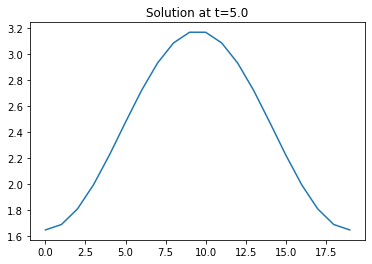

In [7]:
import matplotlib.pyplot as plt

plt.plot(uh)
plt.title('Solution at t=5.0')
plt.show()

In [8]:
pbm   = IFEM_CoSTA.HeatEquation(f'P4/pbm.xinp', verbose=False) # missing source term f
exact = IFEM_CoSTA.HeatEquation(f'P4/P4.xinp',  verbose=False)
mu  = {'dt':0.001, 't':0.0, 'ALPHA':0.7}
uh  = pbm.anasol(mu)['primary']

for n in range(5000):
    u_n      = exact.anasol(mu)['primary'] # u_{n}   exact
    mu['t'] += mu['dt']
    u_np1    = exact.anasol(mu)['primary'] # u_{n+1} exact
    uh       = pbm.predict(mu, u_n)        # u_{n+1} approximated
    sigma    = pbm.residual(mu, u_n, u_np1)# sigma   exact

Assume we try and approximate 
$$ u_t - u_{xx} = f(x,t) $$
i.e.
$$ \mathcal{N} u = f $$
using an approximation
$$ \tilde{\mathcal{N}} \tilde{u} = \tilde{f} $$
Then we can always recover the exact solution, by choising a suitable source correction term $\sigma$
$$ \tilde{\mathcal{N}} u = \tilde{f} +\sigma $$

In this case $\tilde{\mathcal{N}}$ is the FEM discretization in space and backward euler in time and
$$\tilde{f} = 0$$
i.e. we assume that we have inadequate physics description.

We now want a datadriven model to map the residual $\tilde{\mathcal{N}} \tilde{u} - \tilde{f}$ to $\sigma$, i.e. `uh` to `sigma` in the code above

## Creating the data

In [13]:
import numpy as np

pbm   = IFEM_CoSTA.HeatEquation(f'P4/pbm.xinp', verbose=False) # missing source term f
exact = IFEM_CoSTA.HeatEquation(f'P4/P4.xinp',  verbose=False)
mu  = {'dt':0.001, 't':0.0, 'ALPHA':0.7}

# storage matrices for mapping X to Y
X = np.zeros((5000,20)) # 5000 timesteps, 20 degrees of freedom
Y = np.zeros((5000,20))

for n in range(5000):
    u_n      = exact.anasol(mu)['primary'] # u_{n}   exact
    mu['t'] += mu['dt']
    u_np1    = exact.anasol(mu)['primary'] # u_{n+1} exact
    uh       = pbm.predict(mu, u_n)        # u_{n+1} approximated
    sigma    = pbm.residual(mu, u_n, u_np1)# sigma   exact
    
    X[n,:]   = uh
    Y[n,:]   = sigma

### Plot the results just to see what we're working with
This is just for our own curiosity

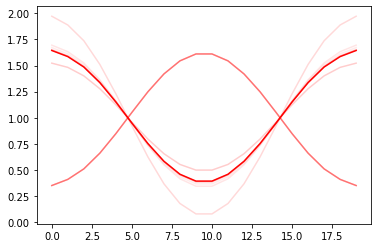

In [31]:
plt.plot(X[1,:],    'r-', alpha=0.05)
plt.plot(X[5,:],    'r-', alpha=0.08)
plt.plot(X[10,:],   'r-', alpha=0.10)
plt.plot(X[100,:],  'r-', alpha=0.15)
plt.plot(X[300,:],  'r-', alpha=0.20)
plt.plot(X[500,:],  'r-', alpha=0.25)
plt.plot(X[1000,:], 'r-', alpha=0.30)
plt.plot(X[2500,:], 'r-', alpha=0.40)
plt.plot(X[4999,:], 'r-', alpha=0.99)
plt.show()

## Build a data drive model
Using your favorite machine learning framework

In [40]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.optimizers import Adam


ham = Sequential()
ham.add(Dense(20,))
ham.add(Dense(80,activation='relu'))
ham.add(Dense(80,activation='relu'))
ham.add(Dense(80,activation='relu'))
ham.add(Dense(20,))

ham.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])


In [41]:
ham.fit(X,Y, batch_size=32, epochs=10)

Epoch 1/10
5000/5000 [==============================] - 0s 81us/step - loss: 0.1264 - mean_absolute_error: 0.2151 - mean_squared_error: 0.1264
Epoch 2/10
5000/5000 [==============================] - 0s 41us/step - loss: 0.0259 - mean_absolute_error: 0.1227 - mean_squared_error: 0.0259
Epoch 3/10
5000/5000 [==============================] - 0s 45us/step - loss: 0.0262 - mean_absolute_error: 0.1228 - mean_squared_error: 0.0262
Epoch 4/10
5000/5000 [==============================] - 0s 45us/step - loss: 0.0257 - mean_absolute_error: 0.1220 - mean_squared_error: 0.0257
Epoch 5/10
5000/5000 [==============================] - 0s 39us/step - loss: 0.0255 - mean_absolute_error: 0.1222 - mean_squared_error: 0.0255
Epoch 6/10
5000/5000 [==============================] - 0s 39us/step - loss: 0.0257 - mean_absolute_error: 0.1220 - mean_squared_error: 0.0257
Epoch 7/10
5000/5000 [==============================] - 0s 40us/step - loss: 0.0260 - mean_absolute_error: 0.1229 - mean_squared_error: 0.0260

# Using the datadriven model


In [46]:
pbm   = IFEM_CoSTA.HeatEquation(f'P4/pbm.xinp', verbose=False) # contains inadequate physics
# exact = IFEM_CoSTA.HeatEquation(f'P4/P4.xinp',  verbose=False)
mu  = {'dt':0.001, 't':0.0, 'ALPHA':0.7}
u_n  = pbm.initial_condition(mu)

for n in range(5000):
    mu['t'] += mu['dt']
    u_pred = pbm.predict(mu, u_n)                             # solve A*u_{n+1} = b(u_{n})
    sigma  = ham.predict(np.array(u_pred, ndmin=2)).flatten() # compute sigma(u_{n+1})
    u_n    = pbm.correct(mu, u_n, sigma)                      # solve A*u_{n+1} = b(u_{n})+sigma

# Some initial results and experimentations

Train model on $alpha \in [0,2]$. Test two unseen $\alpha$ values in the interior of the sampling domain and two outside. Comparing three models
* PBM: Physics-Based Model: with inadequate physics description (here: missing right-hand side source term)
* HAM: Hybrid Analysis and Modelling: described above
* DDM: Data-Driven Method: Pure datadriven, trying to predict $F(T_{n}) = T_{n+1}$

### Interpolating $\alpha$
<img src=P4/test/P4_final_sol_a7.png>
<img src=P4/test/P4_final_sol_a15.png>

### Extrapolating $\alpha$
<img src=P4/test/P4_final_sol_a-5.png>
<img src=P4/test/P4_final_sol_a25.png>

# Plotting the error as a function of time

### Interpolating $\alpha$
<img src=P4/test/P4_error_a7.png>
<img src=P4/test/P4_error_a15.png>

### Extrapolating $\alpha$
<img src=P4/test/P4_error_a-5.png>
<img src=P4/test/P4_error_a25.png>

# Unknown material coefficient

For this example we use inadequate heat conductivity, which means that the system matrix in $Au=b$ are wrong. The previous example had wrong $b(\cdot)$-formulation, while this example has wrong $A(\cdot,\cdot)$-formulation.

In particular we solve
$$ u_t - (\kappa u_x)_x = f(x,t) $$
with
$$\kappa = 5-\frac{\alpha x}{1+t}$$
unknown to the physics-based model

### Interpolating $\alpha$
<img src=k2/test/k2_final_sol_a7.png>

### Extrapolating $\alpha$
<img src=k2/test/k2_final_sol_a-5.png>

## Error plots
### Interpolating $\alpha$
<img src=k2/test/k2_error_a7.png>
<img src=k2/test/k2_error_a15.png>

### Extrapolating $\alpha$
<img src=k2/test/k2_error_a-5.png>
<img src=k2/test/k2_error_a25.png>